## Closed-loop optimisation

The combination of automation and optimisation is powerful. Closed-loop workflows are of growing importance in materials research for many reasons, including:

1. **Efficiency:** Efficient allocation of resources, both in terms of time and materials. By continuously updating experimental parameters based on real-time feedback, the number of trials needed to reach optimal outcomes can be reduced.

2. **Adapt to changing conditions:** Adaptive decision-making, ensuring that experiments remain effective even when external factors fluctuate. This adaptability is highly valuable for complex systems where traditional trial-and-error approaches are prone to fail.

3. **Exploration of large parameter spaces:** Many materials science problems involve high-dimensional parameter spaces where exhaustive exploration is impractical. Techniques such as Bayesian optimisation can efficiently sample and search these spaces to identify optimal configurations and make discoveries.

4. **Data-driven insights:** Generation of valuable data from ongoing experiments. This data can be analysed to gain a deeper understanding of the underlying processes and relationships, facilitating scientific discoveries and supporting future efforts.

In [1]:
# Installation of libraries
%pip install scikit-optimize --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import of modules
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize, dummy_minimize  # Bayesian optimisation
from sklearn.metrics import r2_score  # R-squared metric

np.random.seed(412) # For reproducibility

## Bayesian optimisation (BO)

BO is a powerful technique for optimising complex and expensive-to-evaluate functions. It combines probabilistic modeling and decision theory to search for the optimal set of parameters. In materials research, parameters like chemical composition, sample thickness, and processing conditions can be optimised.

BO aims to find the global minimum (or maximum) of an objective function, $O(x)$, where $x$ represents a set of parameters or design variables. Instead of exhaustive searches, BO builds a surrogate model, typically a Gaussian Process (GP), that approximates the true objective function. This surrogate model captures both the mean $\mu(x)$ and uncertainty $\sigma(x)$ associated with $O(x)$. The GP is defined as:

$$
O(x) \sim \text{GP}(\mu(x), k(x, x'))
$$

where $k(x, x')$ is a kernel function that quantifies the similarity between two input points $x$ and $x'$.

The surrogate model balances exploration and exploitation using an acquisition function $\alpha(x)$, which trades off between exploring uncertain regions and exploiting promising areas:

$$
x_{\text{next}} = \arg \max_x \alpha(x)
$$

Common acquisition functions include Probability of Improvement (PI), Expected Improvement (EI), and Upper Confidence Bound (UCB). Each of these functions aims to maximise the expected gain in performance over the current best solution.

<details>
<summary>Curious about the kernel function?</summary>

The kernel determines the covariance structure of the GP. A commonly used kernel, and the default in `sklearn`, is the Radial Basis Function (RBF):

$$
k(x, x') = \sigma^2 \exp\left(-\frac{\|x - x'\|^2}{2l^2}\right)
$$

where:
- $\sigma^2$ is the **signal variance**, which controls the overall magnitude of function variations,
- $l$ is the **length scale**, which determines how quickly the function values change with respect to input differences.

There are also many other choices, such as the [Matérn kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html), which differ in how they model smoothness and continuity.
</details>

## Building a BO model

### Step 1. Target function

Starting by generating a simple sine-like target function with added noise to keep things interesting, this acts as "virtual experiment".

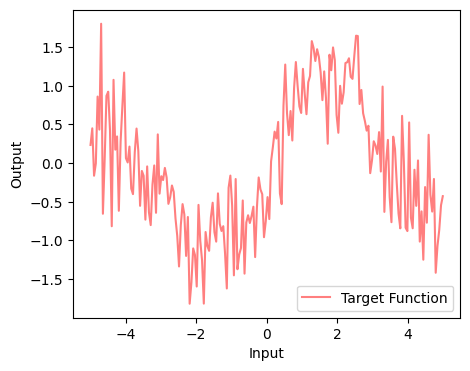

In [2]:
# Fixing the random seed for reproducibility
np.random.seed(412)

# Define the target function
def target_function(x):
    x = np.atleast_1d(x) # Ensure x is an array
    return np.sin(x[0]) + 0.1 * x[0] + 0.5 * np.random.randn()

# Generate data for visualisation
x_values = np.linspace(-5, 5, 200).reshape(-1, 1)
y_values = np.vectorize(target_function)(x_values)

# Plot the target function
plt.figure(figsize=(5, 4))
plt.plot(x_values, y_values, 'r-', alpha=0.5, label='Target Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

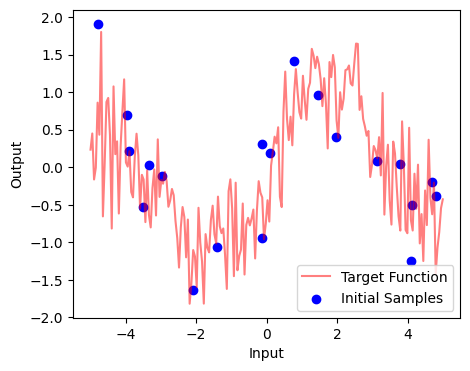

In [3]:
# Generate sample points from the target function
num_initial_points = 20
initial_points = np.random.uniform(-5, 5, num_initial_points)
initial_values = np.vectorize(target_function)(initial_points)

# Plot the sample points
plt.figure(figsize=(5, 4))
plt.plot(x_values, y_values, 'r-', alpha=0.5, label='Target Function')
plt.scatter(initial_points, initial_values, color='blue', marker='o', label='Initial Samples')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

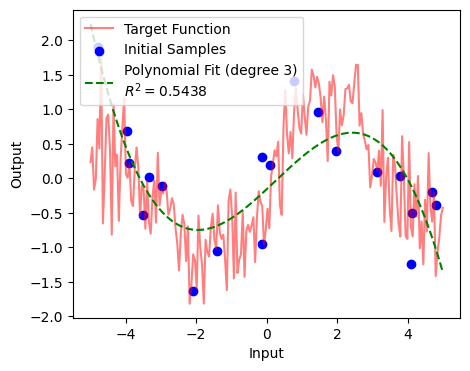

In [4]:
# Perform a polynomial fit
degree = 3 # Adjust the degree of the polynomial fit
coefficients = np.polyfit(initial_points, initial_values, degree)
poly_fit = np.poly1d(coefficients)

# Calculate R^2
y_pred = poly_fit(initial_points)
r_squared = r2_score(initial_values, y_pred)

# Plot the sample points and polynomial fit
plt.figure(figsize=(5, 4))
plt.plot(x_values, y_values, 'r-', alpha=0.5, label='Target Function')
plt.scatter(initial_points, initial_values, color='blue', marker='o', label='Initial Samples')
plt.plot(x_values, poly_fit(x_values), 'g--', label=f'Polynomial Fit (degree {degree})\n$R^2 = {r_squared:.4f}$')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

### Step 3: Gaussian Process

In Bayesian Optimisation with a Gaussian Process model, the optimisation progress is visualised by plotting the target function, optimisation steps, and a colourbar indicating the step number.

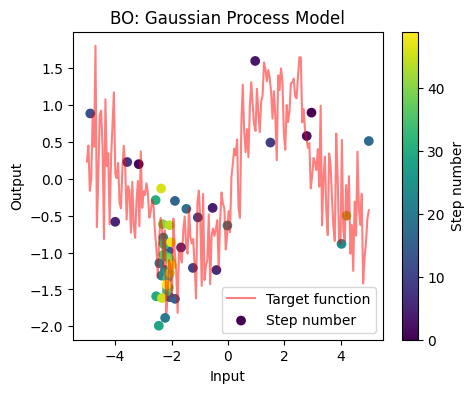

In [5]:
# Optimise the target function using Bayesian Optimisation
result = gp_minimize(target_function, [(-5.0, 5.0)], n_calls=50, random_state=42)
# gp_minimize returns an OptimizeResult object.
# Key attributes of the OptimizeResult object:
# result.x        : The input 'x' that gave the minimum function value (the optimal x)
# result.fun      : The corresponding minimum value of the function y = f(x) at result.x
# result.x_iters  : List of all x values queried during the optimization (all BO steps)
# result.func_vals: List of corresponding y values obtained at each queried x


# Perform random sampling for comparison
random_result = dummy_minimize(target_function, [(-5.0, 5.0)], n_calls=50, random_state=42)

# Plot the Gaussian Process model after optimisation
x_gp = np.array(result.x_iters).reshape(-1, 1)
y_gp = result.func_vals

# Plot the target function
plt.figure(figsize=(5, 4))
plt.plot(x_values, y_values, 'r-', alpha=0.5, label='Target function')

# Plot the optimisation steps with a colormap
plt.scatter(x_gp, y_gp, c=range(len(x_gp)), cmap='viridis', marker='o', label='Step number')

# Add colorbar to indicate the progress
cbar = plt.colorbar()
cbar.set_label('Step number')

plt.title('BO: Gaussian Process Model')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

`plot_gaussian_process` from scikit-optimize can be used to visualise the confidence intervals. `n_samples` determines the number of samples to draw from the Gaussian Process for the estimation.

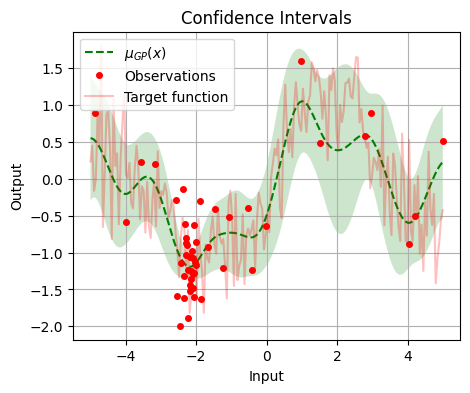

In [6]:
from skopt.plots import plot_gaussian_process as plot_gp

# Plot the Gaussian Process model with confidence intervals
plt.figure(figsize=(5, 4))
plot_gp(result,
        show_observations=True, # show data points
        show_mu=True # show mean curve
        )

# Add the target function for reference
plt.plot(x_values, y_values, 'r-', alpha=0.25, label='Target function')

plt.title('Confidence Intervals')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

The plot shows the GP mean (dashed green), confidence intervals (shaded), and sampled observations (red). The target function (light red) is also overlaid. The confidence region narrows where more observations exist and widens in unexplored areas, reflecting uncertainty in the GP model.

There should be always a benchmark to compare model. This block extracts the best results from BO and random sampling, then compares and visualises their performance over optimisation steps.

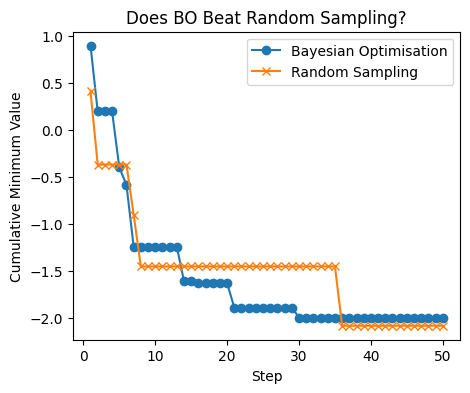

In [7]:
# Extract the cumulative minimum values
bo_min_values = np.minimum.accumulate(result.func_vals)
random_min_values = np.minimum.accumulate(random_result.func_vals)

# Plot the cumulative minimum values vs steps for both methods
plt.figure(figsize=(5, 4))
plt.plot(range(1, len(bo_min_values) + 1), bo_min_values, 'o-', label='Bayesian Optimisation')
plt.plot(range(1, len(random_min_values) + 1), random_min_values, 'x-', label='Random Sampling')

plt.title('Does BO Beat Random Sampling?')
plt.xlabel('Step')
plt.ylabel('Cumulative Minimum Value')
plt.legend()
plt.show()

BO (blue) converges faster to a lower minimum value. Random sampling (orange) fluctuates and struggles to improve beyond a certain point. This highlights BO’s advantage in structured search over purely random exploration.